In [1]:
import tensorflow as tf
import numpy as np
import time

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import cv2

d:\miniconda3\envs\CS530\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#-----------------------------------

IMAGE_SIZE = 28
PERCENT_DATA = 0.1
CODE_SIZE = 16
NUM_HASH_TABLES = 16
FEATURES_LENGTH = 144

'''
    CODE_SIZE = 8, NUM_HASH_TABLES = 4 : 0.5713
    CODE_SIZE = 8, NUM_HASH_TABLES = 8 : 0.6223
    CODE_SIZE = 8, NUM_HASH_TABLES = 16 : 0.6775

    CODE_SIZE = 12, NUM_HASH_TABLES = 4 : 0.5865
    CODE_SIZE = 12, NUM_HASH_TABLES = 8 : 0.6401
    CODE_SIZE = 12, NUM_HASH_TABLES = 16 : 0.6923

    CODE_SIZE = 16, NUM_HASH_TABLES = 4 : 0.5932
    CODE_SIZE = 16, NUM_HASH_TABLES = 8 : 0.6494
    CODE_SIZE = 16, NUM_HASH_TABLES = 16 : 0.6940

    CODE_SIZE = 24, NUM_HASH_TABLES = 4 : 0.6134
    CODE_SIZE = 24, NUM_HASH_TABLES = 8 : 0.6547
    CODE_SIZE = 24, NUM_HASH_TABLES = 16 : 0.6965
'''

#-----------------------------------

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

NUM_TRAIN_IMAGES = int(60000*PERCENT_DATA)
NUM_TEST_IMAGES = int(10000*PERCENT_DATA)

images = np.array(x_train[:NUM_TRAIN_IMAGES])
labels = np.array(y_train[:NUM_TRAIN_IMAGES])

x_test = np.array(x_test[:NUM_TEST_IMAGES])
y_test = np.array(y_test[:NUM_TEST_IMAGES])

#-----------------------------------

cell_size = (8, 8)  # h x w in pixels
block_size = (2, 2)  # h x w in cells
nbins = 9  # number of orientation bins
imgshape = [28, 28]
hog = cv2.HOGDescriptor(_winSize=(imgshape[1] // cell_size[1] * cell_size[1],
                                  imgshape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

class HOG_extractor():
    def predict(image):
        im = np.resize(image, (28, 28))
        feature = hog.compute(im)
        return [feature]
    
embedding_model = HOG_extractor

#-----------------------------------

def hash_func(embedding, random_vectors):
    embedding = np.array(embedding)

    # Random projection.
    bools = np.dot(embedding, random_vectors) > 0
    return [bool2int(bool_vec) for bool_vec in bools]


def bool2int(x):
    y = 0
    for i, j in enumerate(x):
        if j:
            y += 1 << i
    return y


class Table:
    def __init__(self, hash_size, dim):
        self.table = {}
        self.hash_size = hash_size
        self.random_vectors = np.random.randn(hash_size, dim).T

    def add(self, id, vectors, label):
        # Create a unique indentifier.
        entry = {"id_label": str(id) + "_" + str(label)}

        # Compute the hash values.
        hashes = hash_func(vectors, self.random_vectors)

        # Add the hash values to the current table.
        for h in hashes:
            if h in self.table:
                self.table[h].append(entry)
            else:
                self.table[h] = [entry]

    def query(self, vectors):
        # Compute hash value for the query vector.
        hashes = hash_func(vectors, self.random_vectors)
        results = []

        # Loop over the query hashes and determine if they exist in
        # the current table.
        for h in hashes:
            if h in self.table:
                results.extend(self.table[h])
        return results


class LSH:
    def __init__(self, hash_size, dim, num_tables):
        self.num_tables = num_tables
        self.tables = []
        for i in range(self.num_tables):
            self.tables.append(Table(hash_size, dim))

    def add(self, id, vectors, label):
        for table in self.tables:
            table.add(id, vectors, label)

    def query(self, vectors):
        results = []
        for table in self.tables:
            results.extend(table.query(vectors))
        return results

class BuildLSHTable:
    def __init__(
        self,
        prediction_model,
        concrete_function=False,
        hash_size=CODE_SIZE,
        dim=FEATURES_LENGTH,
        num_tables=NUM_HASH_TABLES,
    ):
        self.hash_size = hash_size
        self.dim = dim
        self.num_tables = num_tables
        self.lsh = LSH(self.hash_size, self.dim, self.num_tables)

        self.prediction_model = prediction_model
        self.concrete_function = concrete_function

    def train(self, training_files):
        for id, training_file in enumerate(training_files):
            # Unpack the data.
            image, label = training_file
            if len(image.shape) < 4:
                image = image[None, ...]

            # Compute embeddings and update the LSH tables.
            # More on `self.concrete_function()` later.
            if self.concrete_function:
                features = self.prediction_model(tf.constant(image))[
                    "normalization"
                ].numpy()
            else:
                features = self.prediction_model.predict(image)
            self.lsh.add(id, features, label)

    def query(self, image, map_k=5, verbose=False):
        # Compute the embeddings of the query image and fetch the results.
        if len(image.shape) < 4:
            image = image[None, ...]

        if self.concrete_function:
            features = self.prediction_model(tf.constant(image))[
                "normalization"
            ].numpy()
        else:
            features = self.prediction_model.predict(image)

        results = self.lsh.query(features)
        if verbose:
            print("Matches:", len(results))

        # Calculate Jaccard index to quantify the similarity.
        counts = {}
        for r in results:
            if r["id_label"] in counts:
                counts[r["id_label"]] += 1
            else:
                counts[r["id_label"]] = 1
        for k in counts:
            counts[k] = float(counts[k]) / self.dim
        
        rimages = sorted(counts, key=counts.get, reverse=True)
        return rimages[:map_k]
    

def average_precision_at_k(true_positives, k):
    precision_sum = 0
    relevant_count = 0

    for i in range(k):
        if true_positives[i]:
            relevant_count += 1
            precision = relevant_count / (i + 1)
            precision_sum += precision

    if relevant_count == 0:
        return 0

    average_precision = precision_sum / relevant_count
    return average_precision

def mean_average_precision_at_k(true_labels, k):
    num_queries = len(true_labels)
    map_sum = 0

    for i in range(num_queries):
        true_label = true_labels[i]
        true_positives = [label == 1 for label in true_label]

        ap_at_k = average_precision_at_k(true_positives, k)
        map_sum += ap_at_k

    mean_average_precision = map_sum / num_queries
    return mean_average_precision

if __name__ == '__main__':
    training_files = zip(images, labels)
    lsh_builder = BuildLSHTable(embedding_model)
    lsh_builder.train(training_files)
    
    # y_true = []
    # y_pred = []
    # true_labels = []
    # k = 10
    # for image, label in zip(x_test, y_test):
    #     y_true.append(label)
    #     entrys = lsh_builder.query(image, map_k=k)
    #     y = []
    #     for r in entrys:
    #         image_id, la = r.split("_")[0], r.split("_")[1]
    #         y.append(int(la))
    #     y_pred.append(y)
    #     true_positives = [x == label for x in y]
    #     true_labels.append(true_positives)
    #     print(label, y, true_positives)
    #     while len(true_positives) < k:
    #         true_positives.append(1)

    # map = mean_average_precision_at_k(true_labels, k)
    # print(map)

In [26]:
import matplotlib.pyplot as plt

def plot_images(images, labels):
    plt.figure(figsize=(25, 8))
    columns = 6
    for (i, image) in enumerate(images):
        ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(labels[i]))
        else:
            ax.set_title("Similar Image # " + str(i) + "\nLabel: {}".format(labels[i]))
        plt.imshow(image.astype("int"))
        plt.axis("off")

In [12]:
images = np.array(images)
labels = np.array(labels)
print(images.shape, labels.shape)

(6000, 28, 28) (6000,)


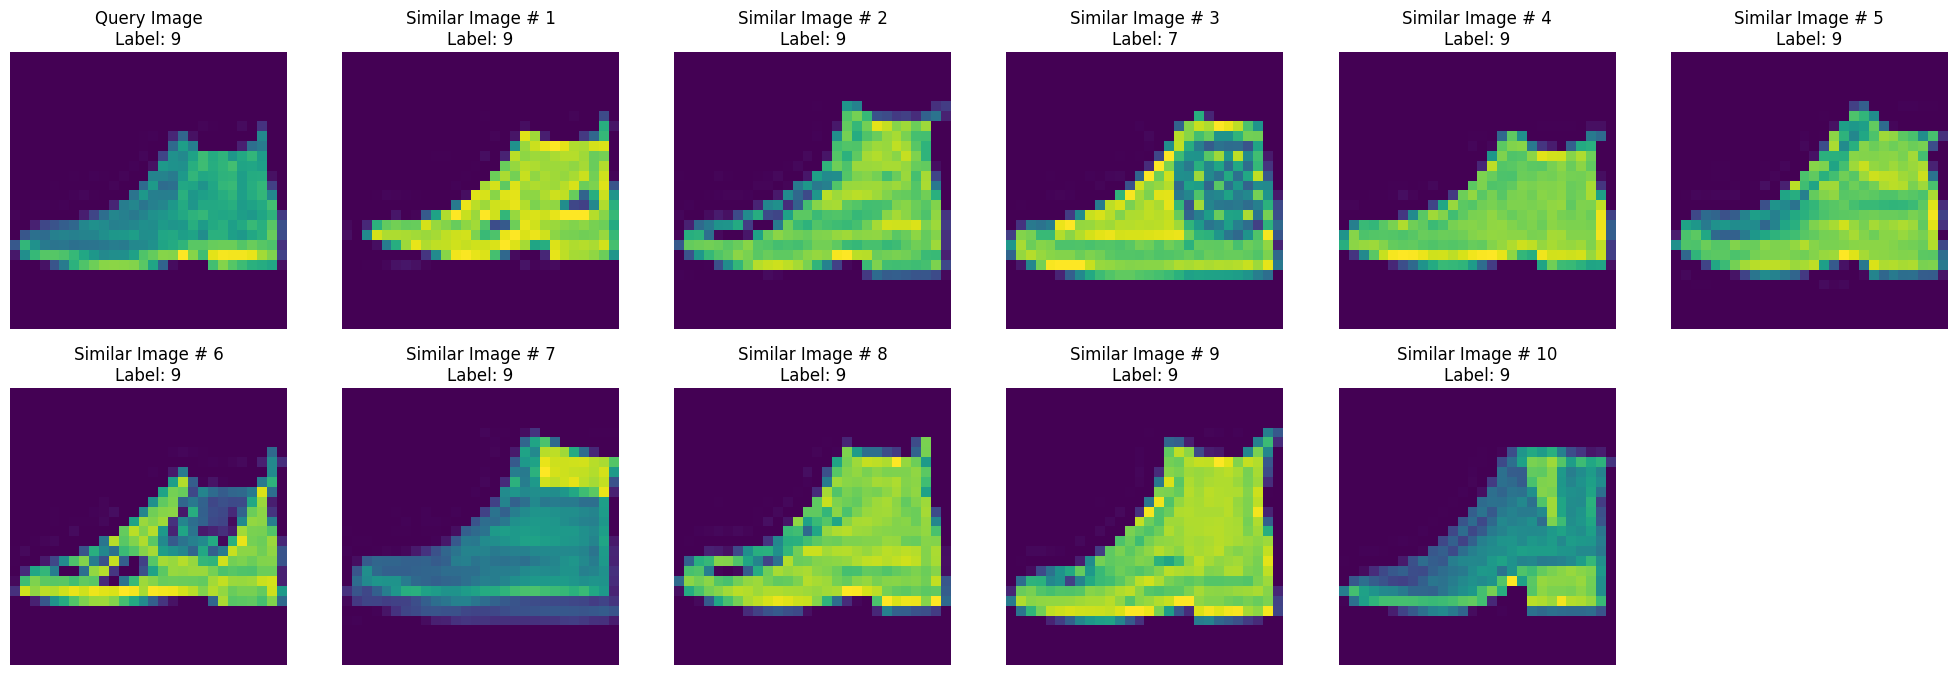

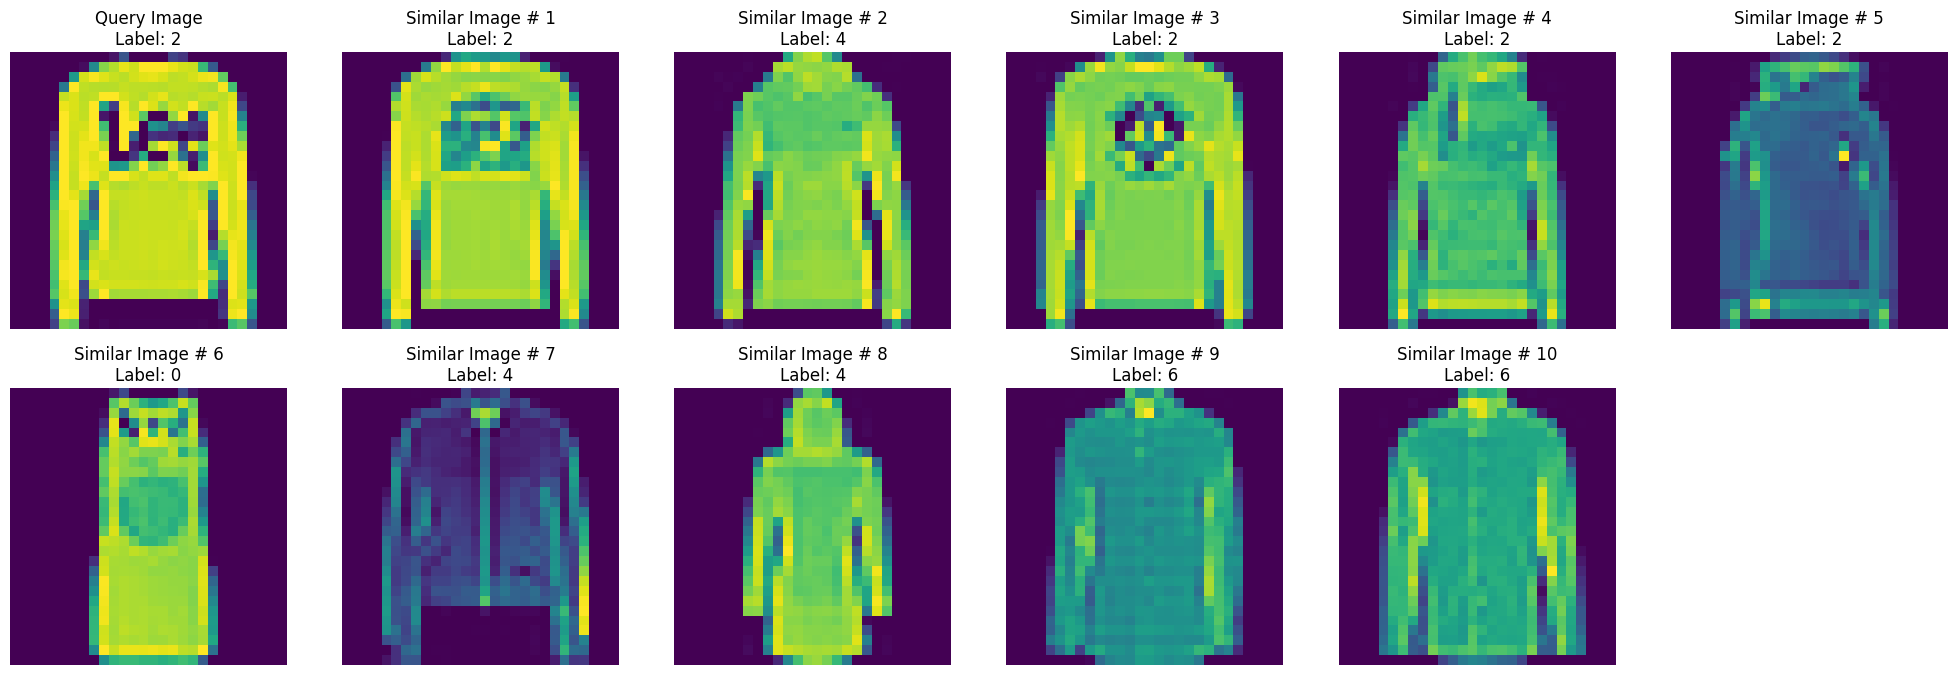

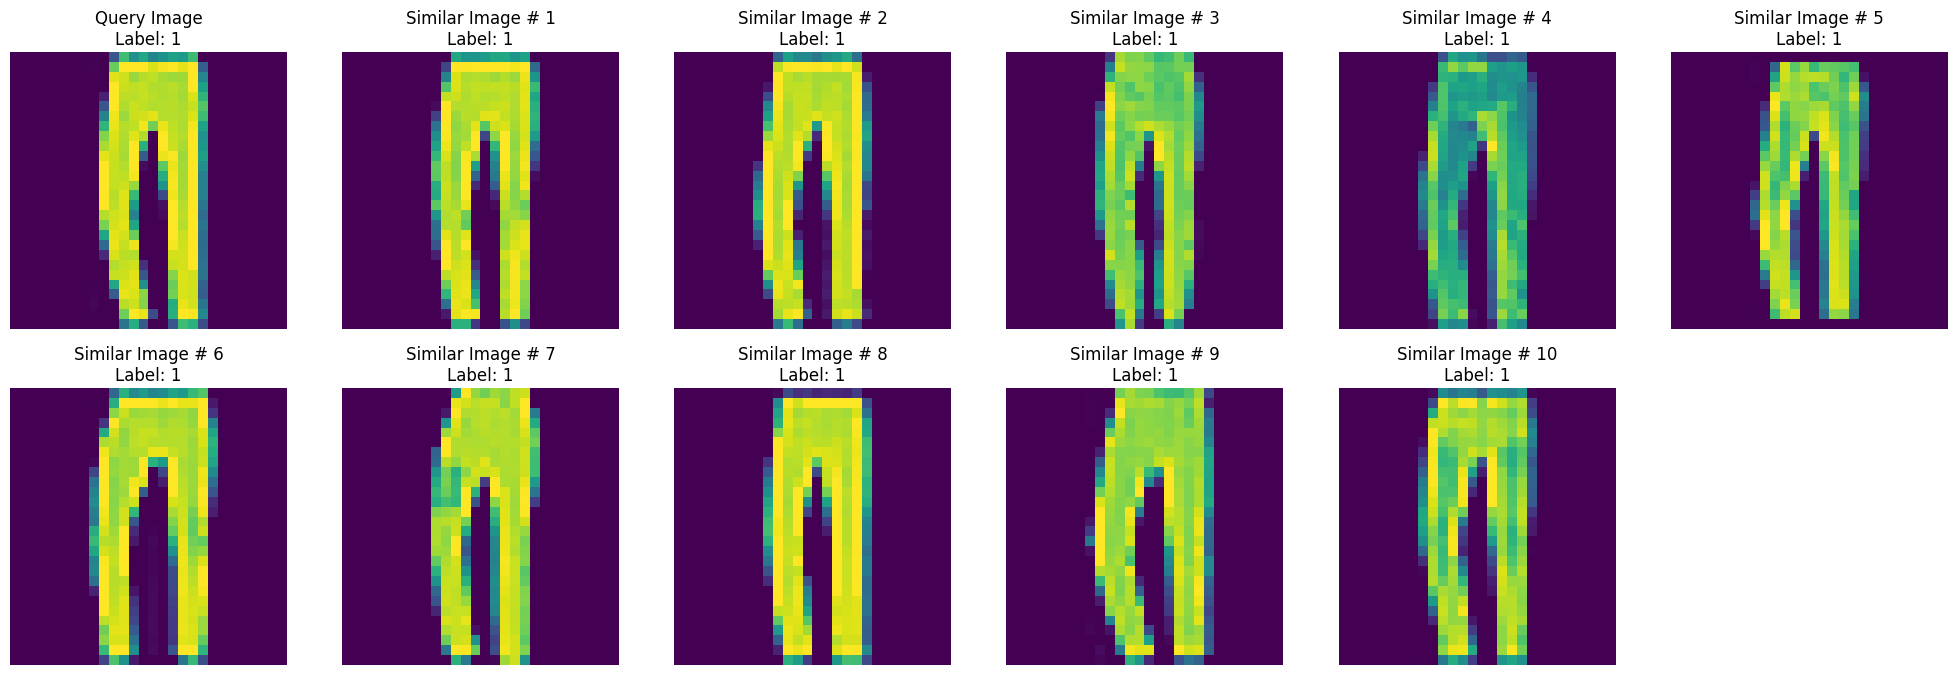

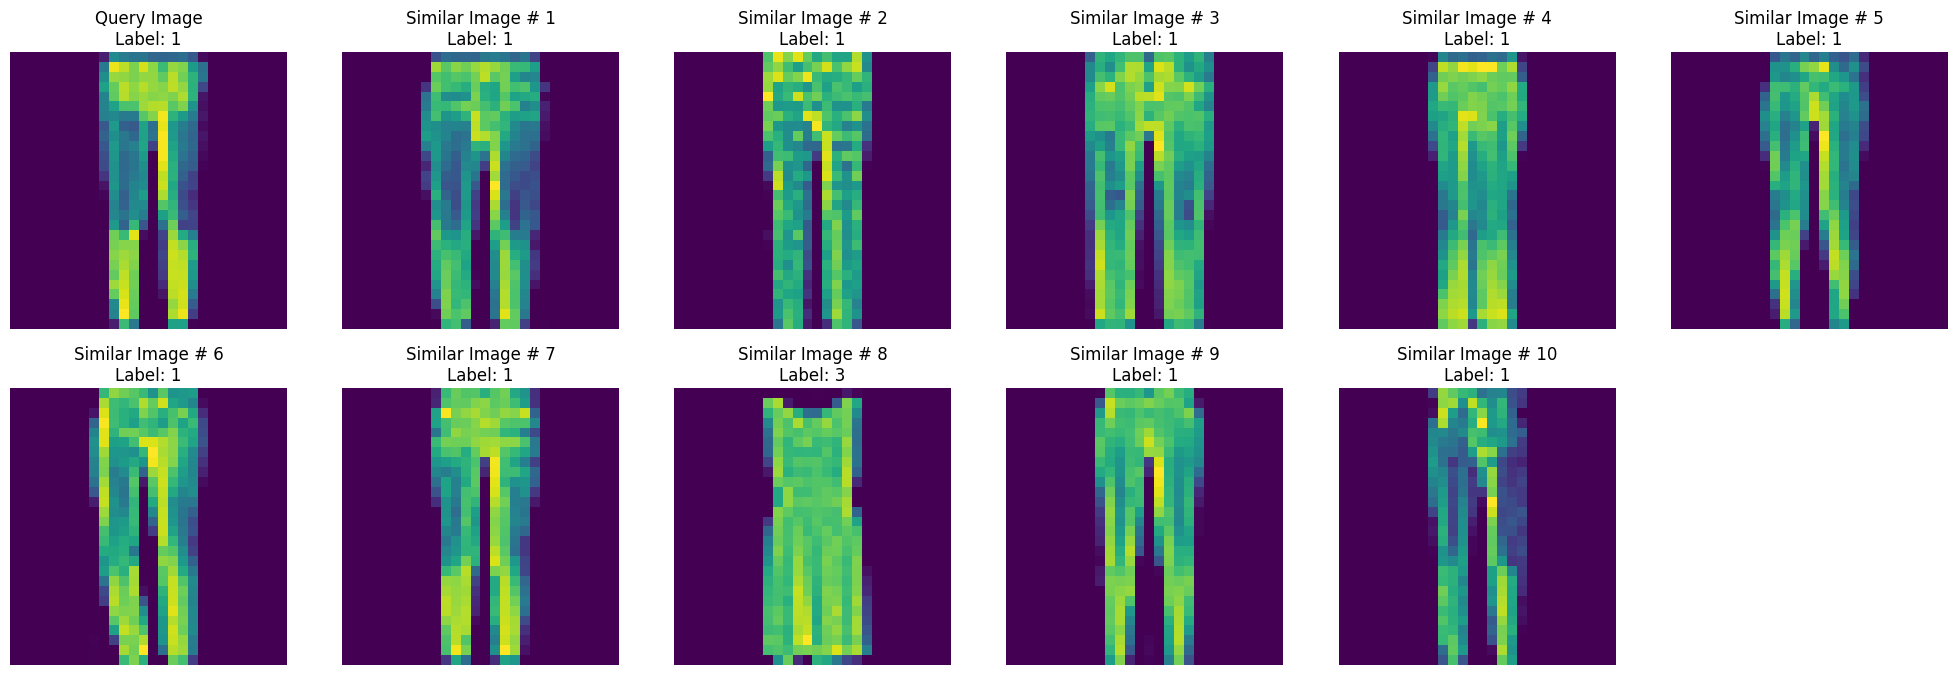

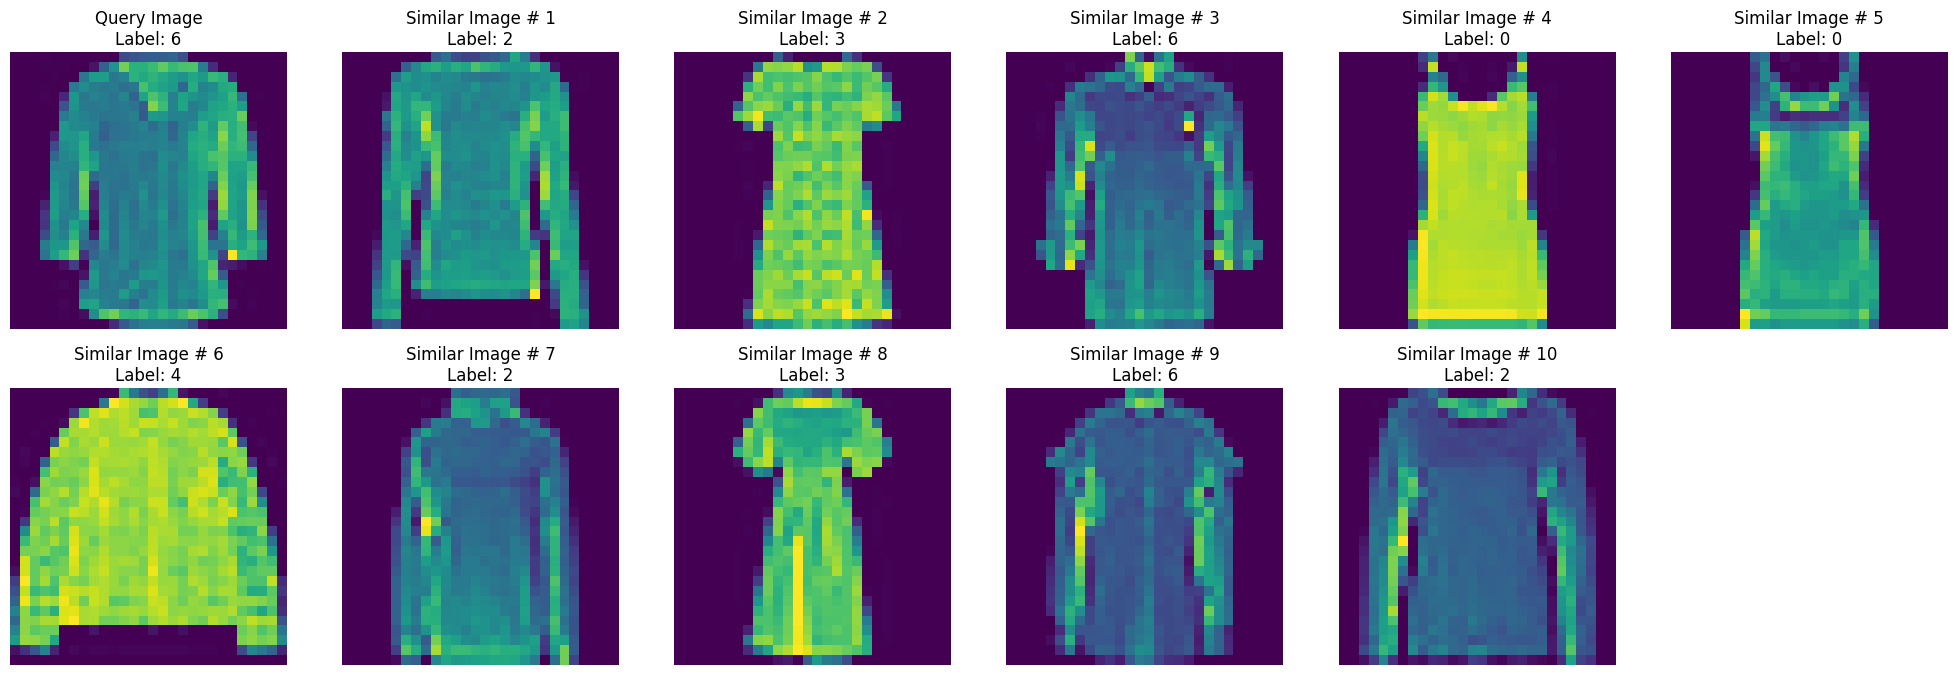

In [27]:
k = 10
idx = 0

for image, label in zip(x_test, y_test):
    entrys = lsh_builder.query(image, map_k=k)
    imgs = [image]
    labs = [label]
    for r in entrys:
        image_id, la = r.split("_")[0], r.split("_")[1]
        imgs.append(images[int(image_id)])
        labs.append(la)

    plot_images(imgs, labs)

    idx += 1
    if idx == 5: 
        break
